In [ ]:
import tensorflow as tf

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(f"RuntimeError: {e}")
else:
    print("No GPUs available.")

import pandas as pd
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, Embedding, LSTM, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as gensim_api_glove
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Memory growth enabled for GPUs.


In [2]:
df = pd.read_csv('../Input/preprocessed.csv', usecols=['class', 'processed_text'])
df.dropna(subset=['processed_text'], inplace=True)
df.dropna(subset=['class'], inplace=True)

In [3]:
X = df['processed_text'].values
tokenizer = Tokenizer(num_words=30000, lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_length = 150
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post')
y=pd.get_dummies(df['class'])

In [4]:
glove_gensim  = gensim_api_glove.load('glove-wiki-gigaword-100')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [6]:
vector_size = 100
num_tokens = 30000
input_length = X_train.shape[1]
gensim_weight_matrix = np.zeros((num_tokens, vector_size))
for word, index in tokenizer.word_index.items():
    if index < num_tokens:
        if word in glove_gensim.index_to_key:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [7]:
model = Sequential()
model.add(Embedding(input_dim=num_tokens, output_dim=vector_size, weights=[gensim_weight_matrix], trainable=False, input_length=input_length))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(250, return_sequences=True)))
model.add(Dropout(0.225))
model.add(Bidirectional(LSTM(300, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(350, return_sequences=True)))
model.add(Dropout(0.5))
model.add(SimpleRNN(100, return_sequences=True))
model.add(Dropout(0.45))
model.add(SimpleRNN(200, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          3000000   
                                                                 
 dropout (Dropout)           (None, 150, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 150, 500)         702000    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 150, 500)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 600)         1922400   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150, 600)          0

In [8]:
class ProgressLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, Accuracy = {logs['accuracy']:.4f}, "
              f"Val_Loss = {logs['val_loss']:.4f}, Val_Accuracy = {logs['val_accuracy']:.4f}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)
mc = ModelCheckpoint('../Models/best_dl_model_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

callbacks = [reduce_lr, early_stop, mc, ProgressLogger()]

In [9]:
print("Training Deep Learning Model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, callbacks=callbacks, verbose=1)

Training Deep Learning Model...
Epoch 1/10
1451/1451 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8517
Epoch 1: val_accuracy improved from -inf to 0.89107, saving model to ../Models\best_dl_model_3.h5
Epoch 1: Loss = 0.3594, Accuracy = 0.8517, Val_Loss = 0.2703, Val_Accuracy = 0.8911
1451/1451 [==============================] - 623s 421ms/step - loss: 0.3594 - accuracy: 0.8517 - val_loss: 0.2703 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 2/10
1451/1451 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8972
Epoch 2: val_accuracy improved from 0.89107 to 0.91066, saving model to ../Models\best_dl_model_3.h5
Epoch 2: Loss = 0.2636, Accuracy = 0.8972, Val_Loss = 0.2355, Val_Accuracy = 0.9107
1451/1451 [==============================] - 609s 420ms/step - loss: 0.2636 - accuracy: 0.8972 - val_loss: 0.2355 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 3/10
1451/1451 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9087
Epoch 3

In [11]:
evaluation = model.evaluate(X_test, y_test)

1451/1451 [==============================] - 191s 132ms/step - loss: 0.2075 - accuracy: 0.9300


In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

1451/1451 [==============================] - 113s 78ms/step


In [30]:
precision = precision_score(np.argmax(y_test, axis=1), y_pred)
recall = recall_score(np.argmax(y_test, axis=1), y_pred)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred)
cf = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [22]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", evaluation[1])
print("Loss:", evaluation[0])

Precision: 0.9031350482315113
Recall: 0.964046679251759
F1 Score: 0.9325973271353863
Accuracy: 0.9300090670585632
Loss: 0.20753958821296692


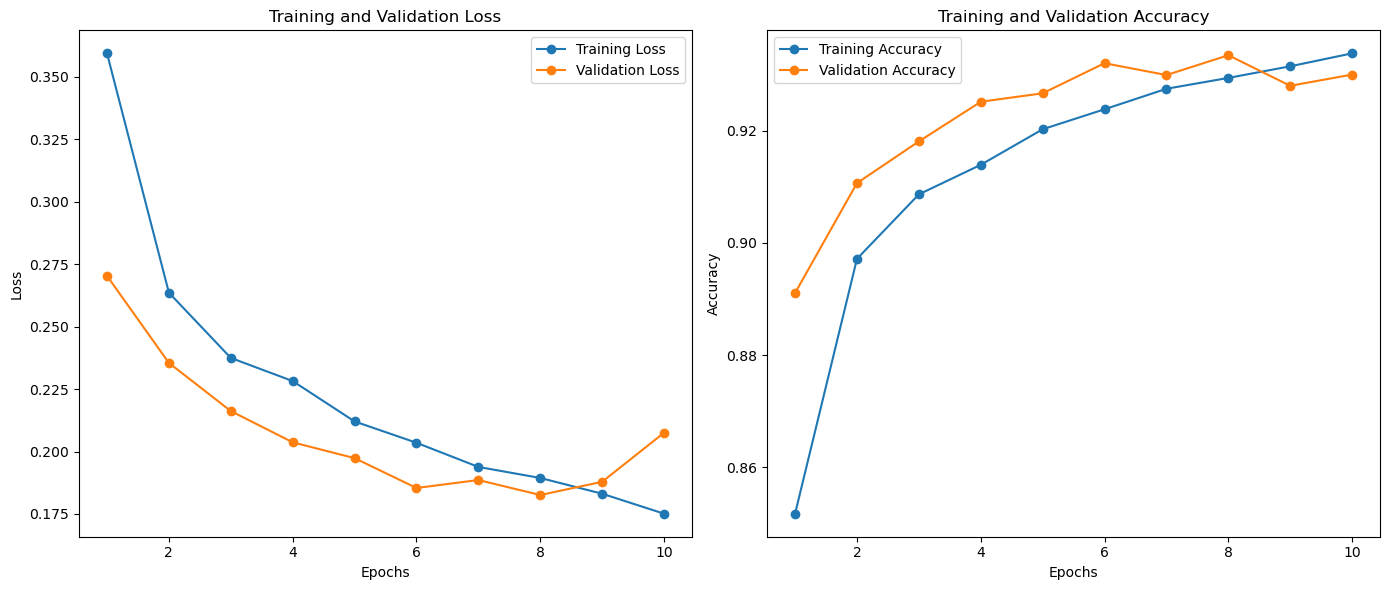

In [36]:
# Extract metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

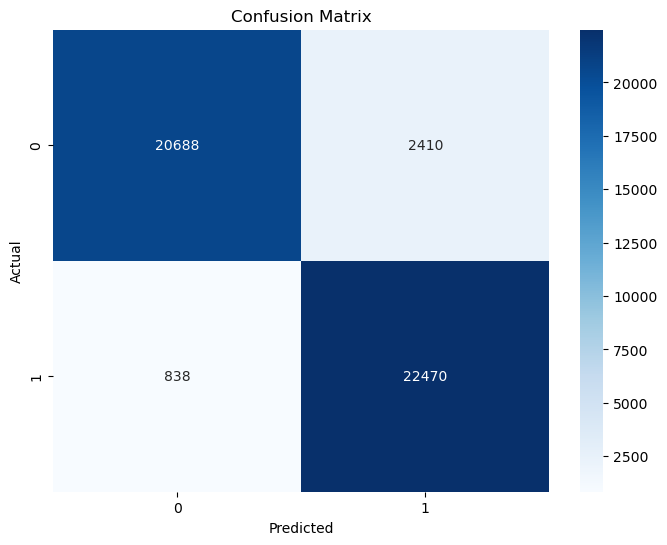

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cf, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
with open('../Models/tokenizer_dl_model_3.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('../Models/history_model_dl_model_3.pkl', 'wb') as f:
    pickle.dump(history.history, f)